# Model Training Notebook on Colab

In [1]:
%matplotlib inline
import sys
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
from datetime import datetime
from IPython.core.display import display, HTML
import cv2
from PIL import Image
from pathlib import Path
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import ast

from sklearn.model_selection import train_test_split

# repeatable functions housed in the utils file and imported here

# us this if you're using Colab
sys.path.insert(1, './drive/MyDrive/OMSCS/CS7643-Final-Project')
from utils import *
from model_training_utils import train as training_loop
from model_training_utils import validate as validation_loop
from model_training_utils import hp_grid_search
from models import CNN, YOLO, VGG, SimpleVGG

print(torch.cuda.is_available())

True


## Create Training and Validation Datasets

In [2]:
df= pd.read_csv('/content/drive/MyDrive/OMSCS/CS7643-Final-Project/datasets/annotations_final.csv', converters= {'new_bb': from_np_array})
df['colab_path']= "/content/drive/MyDrive/OMSCS/CS7643-Final-Project/"+df['new_path']

In [3]:
df_train = df.reset_index()
X = df_train[['colab_path','new_bb']]
Y = df_train['class']
X_train, X_val, y_train, y_val = train_test_split(X, Y, test_size=0.15, random_state=42)

print('Number of training observations: ', X_train.shape[0])
print('Number of validation observations: ', X_val.shape[0])

Number of training observations:  292
Number of validation observations:  52


# Train the Model


- Structured similarly to main.py file from pytorch part of A2

In [4]:
## Define Hyperparameters -- Currently setting values that we can modify
loss_type = "l1"
learning_rate = 0.0001
momentum = 0.9
reg = 1e-2

training_batch_size= 25
validation_batch_size= 25

model_type= "SimpleVGG"

In [5]:
if loss_type == "l1":
    criterion = nn.L1Loss()
    
if loss_type == "l2":
    criterion = nn.MSELoss()

if model_type== "SimpleCNN":
    model= CNN()
elif model_type == "YOLO":
    model = YOLO()  
elif model_type == "VGG":
    model = VGG()
elif model_type == "SimpleVGG":
    model = SimpleVGG()

if torch.cuda.is_available():
    model.cuda()

#if using colab
train_ds = WaldoDataset(X_train['colab_path'], X_train['new_bb'], y_train)
valid_ds= WaldoDataset(X_val['colab_path'], X_val['new_bb'], y_val)

train_dl = DataLoader(train_ds, batch_size=training_batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=validation_batch_size)

optimizer = torch.optim.SGD(model.parameters(), learning_rate,
                            momentum=momentum,
                            weight_decay=reg)

print('The model type is: ', model_type)

The model type is:  SimpleVGG


In [6]:
train_loss, val_loss= training_loop(model= model, 
                                    optimizer = optimizer, 
                                    train_dl= train_dl, 
                                    valid_dl=valid_dl, 
                                    epochs= 60, 
                                    criterion= criterion, 
                                    verbose= True, 
                                    return_loss= True)

./drive/MyDrive/OMSCS/CS7643-Final-Project/model_training_utils.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_bb= torch.tensor(y_bb)


 
--------------------------------------------------------
Training Loss for Epoch 0: 176.31875610351562


./drive/MyDrive/OMSCS/CS7643-Final-Project/model_training_utils.py:75: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_bb= torch.tensor(y_bb)


Validation Loss for Epoch 0: 360.4029006958008
 
--------------------------------------------------------
Training Loss for Epoch 1: 134.26259478400735
Validation Loss for Epoch 1: 200.52122497558594
 
--------------------------------------------------------
Training Loss for Epoch 2: 98.51733488195083
Validation Loss for Epoch 2: 207.55311584472656
 
--------------------------------------------------------
Training Loss for Epoch 3: 99.1114304486443
Validation Loss for Epoch 3: 219.8430404663086
 
--------------------------------------------------------
Training Loss for Epoch 4: 91.09943524528953
Validation Loss for Epoch 4: 199.3432273864746
 
--------------------------------------------------------
Training Loss for Epoch 5: 89.09385322122013
Validation Loss for Epoch 5: 211.10164642333984
 
--------------------------------------------------------
Training Loss for Epoch 6: 88.02634160658893
Validation Loss for Epoch 6: 206.0279998779297
 
------------------------------------------

0.0001


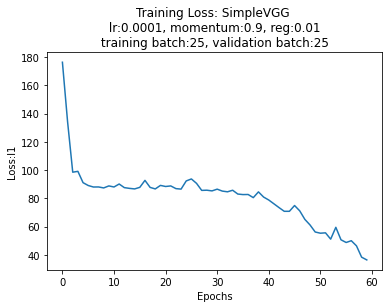

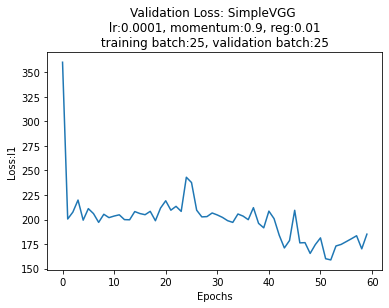

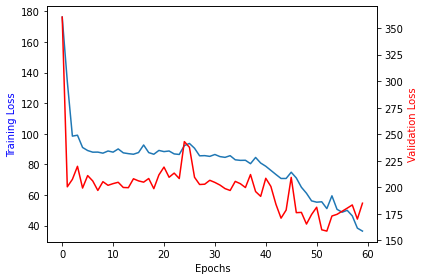

In [7]:

save_figure=False
print(learning_rate)

hp_string= "lr:{0}, momentum:{1}, reg:{2}".format(learning_rate, momentum, reg)
batch_size_string= "training batch:{0}, validation batch:{1}".format(training_batch_size, validation_batch_size)

plt.plot(train_loss)
plt.title('Training Loss: {0} \n {01} \n {2} '.format(model_type,hp_string, batch_size_string))
plt.xlabel('Epochs')
plt.ylabel('Loss:{}'.format(loss_type))
if save_figure:
  plt.savefig("/content/drive/MyDrive/OMSCS/CS7643-Final-Project/figures/{0}-Train-finalDS {1}.png".format(model_type, hp_string))
plt.show()

plt.plot(val_loss)
plt.title('Validation Loss: {0} \n {01} \n {2} '.format(model_type,hp_string, batch_size_string))
plt.xlabel('Epochs')
plt.ylabel('Loss:{}'.format(loss_type))
if save_figure:
  plt.savefig("/content/drive/MyDrive/OMSCS/CS7643-Final-Project/figures/{0}-val-finalDS {1}.png".format(model_type,hp_string))
plt.show()

fig, ax1 = plt.subplots()
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Training Loss', color="blue")
ax1.plot(train_loss)
ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_ylabel('Validation Loss', color= "red")  # we already handled the x-label with ax1
ax2.plot(val_loss, color= "red")
fig.tight_layout()  # otherwise the right y-label is slightly clipped
if save_figure:
  plt.savefig("/content/drive/MyDrive/OMSCS/CS7643-Final-Project/figures/{0}-Combined-finalDS {1}.png".format(model_type, hp_string))
plt.show()


In [7]:
loss_type= ["l1"]
learning_rate= [0.001,0.0001]
momentum = [0.9]
reg = [0.01]
batch_size= [10]

all_training_loss, all_validation_loss= hp_grid_search(model_type= "VGG", 
               lr_list=learning_rate, 
               momentum_list=momentum, 
               reg_list=reg, 
               batch_size_list=batch_size,
               train_ds= train_ds,
               valid_ds= valid_ds,
               optimizer= optimizer, 
               loss_type_list=loss_type,
               epochs= 10,
               save_all_plots="Yes", 
               save_final_plot="Yes",
               final_plot_prefix="Test", 
               return_all_loss= True)

HP ITERATION:  0
learning_rate:  0.001
regularization:  0.01
momentum:  0.9
batch_size:  10
loss type:  l1
VGG_0.001_0.01_0.9_10


UnboundLocalError: ignored